In [ ]:
# TODO:

# From Openstreetmap:
# - What it provides: Distance to city centers, shopping hubs, or transport nodes (e.g., train stations).
# - Population -   "gis_osm_places_free_1"
# - Distance from water - gis_osm_waterways_free_1
# - Distance from transport - gis_osm_transport_a_free_1

# After I process OpenStreetMaps:

# - Use your existing dataset of store locations.
#     - Calculate the density of similar retailers (e.g., supermarkets) within a 1 km radius using geospatial libraries like geopandas or scipy.
# - I want to calculate how the size of each location i.e. x metres squared 
# - Business rates for each location - https://www.data.gov.uk/dataset/f027145b-b55f-4602-b889-b28a8ca04462/business-rates
# Target variable could be size*business rates


Reasonings:
- Overture, AllThePlaces basically only give us the location and type of location (overture). Which is now irrelevant due to the Geolytix dataset
- Geolytix dataset contains retail stored and we have filtered it to the specified region
- Geolytix address is more accurate than OpenLocal so we are using that.

Ideas:
- Once we have a starting point with the dataset, we will subset to 
- Tesco/Sainsburys - get turnover per sq ft
- RateableValue * Weight = Turnover
- Weight can be between 2x - 10x

Data sources:
- ONS Postcode LSOA look up - https://geoportal.statistics.gov.uk/datasets/e7824b1475604212a2325cd373946235/about
- ONS small area GVA estimates - https://www.ons.gov.uk/economy/grossvalueaddedgva/datasets/uksmallareagvaestimates
- ONS Population - https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationandmigrationstatisticstransformationlowerlayersuperoutputareapopulationdifferenceenglandandwales
- ONS Household income - https://www.ons.gov.uk/economy/regionalaccounts/grossdisposablehouseholdincome/datasets/ukgrossdisposablehouseholdincomegdhiforothergeographicareas
- Geolytix - https://drive.google.com/file/d/1B8M7m86rQg2sx2TsHhFa2d-x-dZ1DbSy/view
- OpenLocal - https://drive.google.com/drive/folders/1q2LJ-5U41rxGPUpirC3i0QLhiYVaixlR
- OpenStreetMap - https://download.geofabrik.de/europe/united-kingdom/england/greater-manchester.html

Definitions:
- GVA: Gross Value Added
- TTWA: Travel to Work Areas
- GDHI: Gross Disposable Household Income
- Town: Towns and cities
- WGPC: WEstminster Government Parliamentary Constituency
- CCG: CLinical Commissioning Groups



Process:
- Filtering out businesses that haven't got a rateable value
- Sectors that occur at least 500 times so that we can assign multipliers to each sector and the rest are defaulted to 5. 
    - Reasons being is because there would be too many sectors to assign multipliers to.


Justifications for Assigned Multipliers
Offices (Inc Computer Centres) (3-5):

Turnover is typically moderate, reflecting service-based revenue models. High-value locations may push the multiplier higher.
Shops (2-4):

Retail turnover varies widely based on location and footfall. Smaller shops lean toward the lower end of the range.
Factories, Workshops and Warehouses (2-3):

These properties generate turnover through production or storage, often lower than customer-facing businesses.
Car Spaces (1-2):

Revenue is limited to parking fees or leasing, which generally results in low turnover.
Stores (2-3):

Similar to warehouses but may include retail storage with slightly higher potential turnover.
Advertising Right (1-2):

Turnover is low, based on rental income from advertising space.
Showrooms (3-6):

High turnover potential due to customer-facing sales, particularly for high-value items like vehicles.
Public Houses/Pub Restaurants (6-8):

These establishments are high-turnover businesses, especially in urban or high-traffic locations.
Communication Stations (1-2):

These generate revenue from leases or operational income, typically low turnover.
Restaurants (3-5):

Moderate to high turnover depending on size, location, and clientele.
Hairdressing/Beauty Salons (2-4):

Service-based turnover with some variation based on customer volume and pricing.
Pitches for Stalls, Sales or Promotions (2-3):

Revenue is often event-driven, with relatively low turnover.
Land Used For Storage (1-2):

Minimal revenue generation, primarily leasing income.
Vehicle Repair Workshops & Garages (2-4):

Turnover is service-based and varies depending on size and customer base.
Local Authority Schools (1-1):

Not-for-profit entities with minimal revenue turnover.
Independent Distribution Network Operators (1-2):

Revenue is derived from infrastructure leases or limited operational fees.
Car Parks (Surfaced Open) (1-2):

Revenue is fee-based and depends on location and usage.
Cafes (3-5):

Moderate turnover driven by high footfall and customer frequency.
Day Nurseries/Play Schools (2-4):

Service-based revenue tied to enrolment, with moderate turnover.
Surgeries, Clinics, Health Centres (2-3):

Revenue depends on healthcare services provided but is generally low to moderate.
Community Day Centres (1-2):

Primarily non-commercial entities with minimal turnover.

Standard Reasoning:
The assigned multipliers reflect the turnover potential of each sector, considering:

Customer Interaction: Sectors with direct customer interaction (e.g., restaurants, pubs, showrooms) have higher multipliers.
Revenue Model: Businesses generating rental or service fees (e.g., car parks, communication stations) have lower multipliers.
Sector-Specific Trends: Industries with higher-value transactions or production capabilities have proportionally higher multipliers.
Non-Commercial Properties: Minimal multipliers are applied to sectors like schools or community centers, which do not operate for profit.

In [1]:
import pandas as pd
import geopandas as gpd
import utils
import numpy as np

from importlib import reload 
reload(utils)

pd.set_option('display.max_columns', None)

# Data Prep

In [2]:
gdf = gpd.read_file("data/raw/openlocal/GeoTAM_Hackathon_OpenLocal.gpkg")
gdf["longitude"] = round(gdf.geometry.x, 6)
gdf["latitude"] = round(gdf.geometry.y, 6)

gdf = gdf[[
    'geometry', 'longitude', 'latitude',
    'voapropertyaddress', 'voapropertytown','voapropertycounty', 'voapropertypostcode', 'voapostcodecentroid',
    "voabillingauthoritycode", "voascatcode", "voascatname", 'voafloorarea', 'voarateablevalue', 
    'laratespaid', 'laratesreliefs', 
]]

min_lon, max_lon, min_lat, max_lat = gdf.longitude.min(), gdf.longitude.max(), gdf.latitude.min(), gdf.latitude.max()
df = gdf[(gdf["voarateablevalue"] != "")]

convert_numerical_cols = ["voafloorarea", "voarateablevalue", "laratespaid", ]
for col in convert_numerical_cols:
    df[col] = df[col].apply(lambda x: float(x) if len(x) > 0 else -9999)


df = utils.using_ons_datasets(df, postcode="voapropertypostcode")


c:\Users\wail.baalawi\AppData\Local\anaconda3\envs\geomind_env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\wail.baalawi\OneDrive - Precisely Software Incorporated\Documents\Personal Projects\geomind\utils.py:81: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ons_lookup = pd.read_csv("data/raw/ons/PCD_OA_LSOA_MSOA_LAD_MAY22_UK_LU.csv", encoding="latin-1")


In [3]:
sector_multipliers = {
    'Offices (Inc Computer Centres)': (3, 5),
    'Shops': (2, 4),
    'Factories, Workshops and Warehouses (Incl Bakeries & Dairies)': (2, 3),
    'Car Spaces': (1, 2),
    'Stores': (2, 3),
    'Advertising Right': (1, 2),
    'Showrooms': (3, 6),
    'Public Houses/Pub Restaurants (National Scheme)': (6, 8),
    'Communication Stations (National Scheme)': (1, 2),
    'Restaurants': (3, 5),
    'Hairdressing/Beauty Salons': (2, 4),
    'Pitches for Stalls, Sales or Promotions': (2, 3),
    'Land Used For Storage': (1, 2),
    'Vehicle Repair Workshops & Garages': (2, 4),
    'Local Authority Schools (National Scheme)': (1, 1),  # Minimal turnover
    'Independent Distribution Network Operators (INDOs)': (1, 2),
    'Car Parks (Surfaced Open)': (1, 2),
    'Cafes': (3, 5),
    'Day Nurseries/Play Schools': (2, 4),
    'Surgeries, Clinics, Health Centres (Rental Valuation)': (2, 3),
    'Community Day Centres': (1, 2),
    'Other': (5,5)
}

In [4]:
def get_multiplier(sector):
    return sector_multipliers.get(sector, sector_multipliers['Other'])
def calculate_turnover(row):
    rv = row['voarateablevalue']
    if rv <= 0:
        return None  # Exclude negative or missing values
    multiplier_range = get_multiplier(row['voascatname'])
    multiplier = sum(multiplier_range) / 2  # Use the average of the range
    return rv * multiplier

df['turnover_estimate'] = df.apply(calculate_turnover, axis=1)


In [ ]:
drop_cols = [
    "geometry", "longitude", "latitude", "latitude", 
    "voapropertyaddress", "voapropertytown", "voapropertycounty", 
    "voapropertypostcode", "voapostcodecentroid", 
    "voabillingauthoritycode", "voascatcode", "voascatname", 
    "laratesreliefs", "lsoa", "ttwa_code", "town_code", "pc_code", "ward_code", 
    "ccg_code",
    "voarateablevalue"
    ]
target = "turnover_estimate"




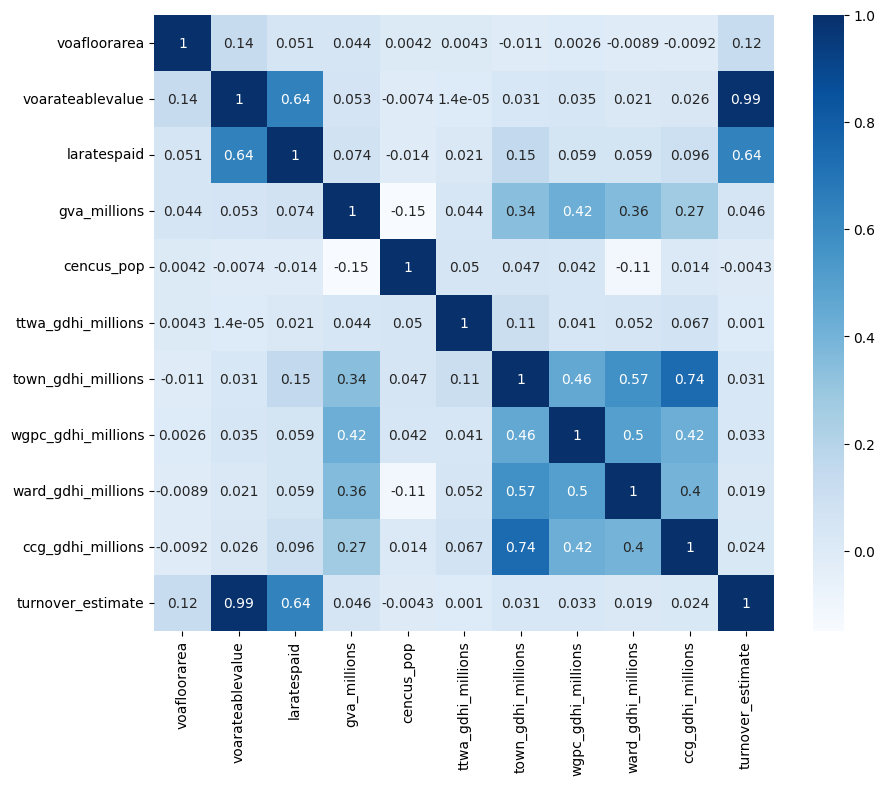

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(df.drop(drop_cols, axis=1).corr(), annot=True, cmap="Blues")
plt.show()

# Baseline Model 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

X = df.drop([*drop_cols, target], axis=1)
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

print(f"sum of y_test: {sum(y_test)}")
print(f"sum of predictions: {sum(y_pred)}")

X_test["actual"] = y_test
X_test["preds"] = y_pred

RMSE: 496127.65782056045
MAPE: 3.907901329054553
sum of y_test: 2243835664.0
sum of predictions: 2276394496.0


In [16]:
X_test[X_test.preds < 0]

,voafloorarea,laratespaid,gva_millions,cencus_pop,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions,actual,preds
73914,1.00,-9999.0,701.256725,2835.0,54907.789249,2459.128607,1955.980162,236.424048,6746.942710,600.0,-30166.531250
85843,1.00,3500.0,5738.148057,1395.0,54907.789249,10101.226153,2748.561603,384.784778,9910.778802,5250.0,-1056.294556
49890,2.80,1225.0,213.040973,2210.0,54907.789249,10101.226153,1963.498350,306.336082,9910.778802,3562.5,-8143.791016
34809,2.00,-9999.0,37.021414,2445.0,54907.789249,10101.226153,2748.561603,247.819970,9910.778802,1275.0,-31708.378906
2945,1.00,1275.0,167.005325,2290.0,54907.789249,10101.226153,2748.561603,316.308693,9910.778802,1912.5,-2251.548584
...,...,...,...,...,...,...,...,...,...,...,...
69477,4.65,-9999.0,86.653870,1590.0,54907.789249,1821.032975,2075.865694,179.775617,3919.397960,512.5,-66.390717
82617,9.29,-9999.0,86.653870,1590.0,54907.789249,1821.032975,2075.865694,179.775617,3919.397960,1037.5,-66.390717
8354,2.00,-9999.0,246.490450,2085.0,54907.789249,NaN,2171.427224,246.031391,5087.413199,750.0,-24199.314453
31737,1.00,3191.5,43.220845,1455.0,54907.789249,443.220032,1670.367036,269.769064,5344.866788,15000.0,-3283.988037


# Adding geospatial features (calculating distance)

# Archive

In [ ]:
# overture_df = utils.extract_overture_data(min_lon, max_lon, min_lat, max_lat)
# atp_df = utils.extract_all_the_places_data(min_lon, max_lon, min_lat, max_lat)

geolytix_df = pd.read_csv("data/raw/geolytix/geolytix_retailpoints_v33_202408.csv").rename(columns={"long_wgs":"longitude", "lat_wgs":"latitude"})
geolytix_df = geolytix_df[
    (geolytix_df["longitude"] >= min_lon) & (geolytix_df["longitude"] <= max_lon) & (geolytix_df["latitude"] >= min_lat) & (geolytix_df["latitude"] <= max_lat)
]
geolytix_df["longitude"] = round(geolytix_df["longitude"], 6)
geolytix_df["latitude"] = round(geolytix_df["latitude"], 6)

retail_df = geolytix_df.merge(
    gdf.drop(["geometry", "longitude", "latitude", 'voapropertyaddress', 'voapropertytown','voapropertycounty', 'voapropertypostcode', 'voapostcodecentroid'], axis=1), 
    on=["add_one"], how="left")
retail_df = retail_df.replace(r'^\s*$', np.nan, regex=True)
def count_non_null(row):
    return row.notnull().sum()
retail_df['non_null_count'] = retail_df.apply(count_non_null, axis=1)
retail_df = retail_df.sort_values(by=['id', 'non_null_count'], ascending=[True, False])
retail_df = retail_df.drop_duplicates(subset=['id'], keep='first')

df = utils.using_ons_datasets(retail_df)


c:\Users\wail.baalawi\OneDrive - Precisely Software Incorporated\Documents\Personal Projects\geomind\utils.py:81: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ons_lookup = pd.read_csv("data/raw/ons/PCD_OA_LSOA_MSOA_LAD_MAY22_UK_LU.csv", encoding="latin-1")


In [6]:
df.isna().sum()

id                           0
retailer                     0
fascia                       0
store_name                   0
add_one                      0
add_two                    441
town                         0
suburb                      50
postcode                     0
longitude                    0
latitude                     0
bng_e                        0
bng_n                        0
pqi                          0
open_date                  440
size_band                    0
county                       0
voabillingauthoritycode    509
voascatcode                509
voascatname                509
voafloorarea               514
voarateablevalue           523
laratespaid                574
laratesreliefs             619
non_null_count               0
lsoa                         3
gva_millions                 3
cencus_pop                   3
ttwa_code                    3
town_code                    4
pc_code                      3
ward_code                    3
ccg_code

In [6]:
df[df.id == 1010003132]


,id,retailer,fascia,store_name,add_one,add_two,town,suburb,postcode,longitude,latitude,bng_e,bng_n,pqi,open_date,size_band,county,voabillingauthoritycode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid,laratesreliefs,non_null_count,lsoa,gva_millions,cencus_pop,ttwa_code,town_code,pc_code,ward_code,ccg_code,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions
123,1010003132,Sainsburys,Sainsburys,Sainsburys Ashton Moss,2 LORD SHELDON WAY,NaN,Ashton Under Lyne,Waterloo,OL6 7TE,-2.105918,53.491396,393070.001028,399414.998877,Rooftop,NaN,"30,138 ft2 > (2,800 m2)",Greater Manchester,E08000008,139,Hypermarkets/Superstores (over 2500m^2),7097.41,1240000.0,677040.0,NaN,21,E01005948,418.249581,2245.0,E30000239,E35000787,E14000537,E05000816,E38000182,54907.789249,768.690987,1657.648548,193.535906,4823.099348


In [ ]:
# Resuming with Openstreetmap data... (see above for task list)

In [131]:
gpd.read_file("data/raw/openstreetmap/gis_osm_railways_free_1.shp")

,osm_id,code,fclass,name,layer,bridge,tunnel,geometry
0,928999,6101,rail,Liverpool to Manchester Line,0,F,F,"LINESTRING (-2.28446 53.48026, -2.29499 53.481..."
1,929904,6101,rail,Liverpool to Manchester Line,0,F,F,"LINESTRING (-2.2918 53.46196, -2.29249 53.4618..."
2,929905,6102,light_rail,Metrolink,0,F,F,"LINESTRING (-2.2794 53.46058, -2.27997 53.46022)"
3,3663332,6102,light_rail,None,0,F,F,"LINESTRING (-2.23821 53.4818, -2.23817 53.4817..."
4,3996086,6101,rail,West Coast Main Line,0,F,F,"LINESTRING (-2.60031 53.46043, -2.60053 53.460..."
...,...,...,...,...,...,...,...,...
3892,1319220899,6101,rail,Hope Valley Line Rosehill Branch,0,F,F,"LINESTRING (-2.06548 53.40654, -2.0657 53.4066..."
3893,1319220900,6101,rail,Hope Valley Line Rosehill Branch,0,F,F,"LINESTRING (-2.06584 53.40683, -2.06571 53.406..."
3894,1319220901,6101,rail,Hope Valley Line Rosehill Branch,0,F,F,"LINESTRING (-2.06719 53.40319, -2.0668 53.4034..."
3895,1319223135,6101,rail,Hope Valley Line,0,F,F,"LINESTRING (-2.11232 53.42372, -2.1115 53.42343)"


In [5]:
overture_df["categories_primary"] = overture_df.categories.fillna("Unknown").apply(lambda x: x["primary"] if isinstance(x, dict) else "Unknown")

In [15]:
tesco_overture = overture_df[overture_df.names_primary.str.startswith("TESCO")]
print(tesco_overture.shape)
tesco_atp = atp_df[atp_df.spider_id.str.startswith("tesco")]
print(tesco_atp.shape)
tesco_test = tesco_atp.merge(tesco_overture[["names_primary", "longitude", "latitude", "categories", "categories_primary"]], on=["longitude", "latitude"],  how="left")

(220, 11)
(162, 12)


In [29]:
tesco_overture[
    (tesco_overture["longitude"] == -2.425578)
    & (tesco_overture["latitude"] == 53.418544)
     
]

,id,names_primary,address,city,state,postcode,geometry,longitude,latitude,categories,categories_primary
1169,08f1951a059142a103e72af6e55ccedc,TESCO EXPRESS,CENTRAL RD,PARTINGTON,None,M31 4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",-2.425578,53.418544,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket


In [33]:
tesco_test[tesco_test["postcode"].str.startswith("M31")]
tesco_test

,longitude,latitude,spider_id,shop,full_address,address,city,postcode,business_name,branch,website,brand,names_primary,categories,categories_primary
0,-2.353317,53.517281,tesco_gb,convenience,NaN,Former Brook Tavern 656 Manchester Rd,NaN,M27 9RA,Tesco Express,Manchester Swinton,https://www.tesco.com/store-locator/worsley/fo...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket
1,-2.205895,53.349625,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Pharmacy,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN
2,-2.202831,53.349394,tesco_gb,NaN,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN
3,-2.205893,53.349615,tesco_gb,supermarket,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco Extra,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco Extra,NaN,NaN,NaN
4,-2.205924,53.349493,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Café,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/k...,Tesco,TESCO CAFE,"{'primary': 'shopping_center', 'alternate': ['...",shopping_center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-2.347290,53.385508,tesco_gb,NaN,NaN,Manor Road,NaN,WA15 9QT,Tesco Pharmacy,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco,TESCO PHARMACY,"{'primary': 'pharmacy', 'alternate': ['drugsto...",pharmacy
158,-2.347339,53.385499,tesco_gb,NaN,NaN,Manor Road,NaN,WA15 9QT,Tesco Café,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco,TESCO CAFE,"{'primary': 'cafe', 'alternate': ['restaurant']}",cafe
159,-2.347299,53.385554,tesco_gb,supermarket,NaN,Manor Road,NaN,WA15 9QT,Tesco Extra,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Extra,NaN,NaN,NaN
160,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket


In [31]:
gdf[gdf["voapropertypostcode"].str.startswith("M31 4EL")]

,_uid_,ogc_fid,voabillingauthoritycode,voabillingauthorityname,voabillingauthorityrefcode,voauarn,labillingreferencecode,laratepayername,laaccountstartdate,larecorddate,laoccupationstate,laoccupationstatedate,laratespaid,laratesreliefs,laratesreliefsamount,laratesreliefsdate,voapropertyaddress,voapropertytown,voapropertycounty,voapropertypostcode,voapostcodecentroid,lacorrespondenceaddress,voascatcode,voascatname,voasubcategory,voacategory,voastartdate,voafloorarea,voarateablevalue,laupdatecycle,voaepoch,geometry,longitude,latitude
17249,17250,2755665,E08000009,Trafford,,196423116,22630675,,,,,,,,,,"SHOP A SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,54.1,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17250,17251,2754343,E08000009,Trafford,,76719116,22630350,,,,,,,,,,"6 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,50.9,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17251,17252,2754344,E08000009,Trafford,,76720116,22630375,,,,,,,,,,"7 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,52.5,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17252,17253,2754345,E08000009,Trafford,,76721116,22630400,,,,,,,,,,"8 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,55.1,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17253,17254,2754329,E08000009,Trafford,,76698116,22630725,,,,,,,,,,"SHOP C SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,024,Betting Offices,RETAIL_FINANCIAL_AND_PROFESSIONAL_SERVICES,RETAIL,2011-03-22,48.8,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17254,17255,2754330,E08000009,Trafford,,76704116,22630550,,,,,,,,,,"15 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,021,Banks/Insurance/Building Society Offices & Oth...,RETAIL_FINANCIAL_AND_PROFESSIONAL_SERVICES,RETAIL,2014-06-17,144.33,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17255,17256,2754331,E08000009,Trafford,,76705116,22630125,,,,,,,,,,"1 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,55.8,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17256,17257,2754332,E08000009,Trafford,,76706116,22630450,,,,,,,,,,"10/10A SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,254.03,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17257,17258,2754333,E08000009,Trafford,,76707116,22630475,,,,,,,,,,"11 AND 12 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,205.1,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17258,17259,2754334,E08000009,Trafford,,76708116,22630500,,,,,,,,,,"13 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,87.5,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873


In [21]:
tesco_test.merge(
    gdf[["longitude", "latitude", "voapropertypostcode", "voascatcode", "voascatname", "voafloorarea", "voarateablevalue", "laratespaid"]],
    on=["longitude", "latitude"],  how="left"
)

,longitude,latitude,spider_id,shop,full_address,address,city,postcode,business_name,branch,website,brand,names_primary,categories,categories_primary,voapropertypostcode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid
0,-2.353317,53.517281,tesco_gb,convenience,NaN,Former Brook Tavern 656 Manchester Rd,NaN,M27 9RA,Tesco Express,Manchester Swinton,https://www.tesco.com/store-locator/worsley/fo...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.205895,53.349625,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Pharmacy,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.202831,53.349394,tesco_gb,NaN,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2.205893,53.349615,tesco_gb,supermarket,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco Extra,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco Extra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.205924,53.349493,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Café,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/k...,Tesco,TESCO CAFE,"{'primary': 'shopping_center', 'alternate': ['...",shopping_center,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,409,Cafes,67.55,4900.0,
164,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,018,ATMs,1.0,,
165,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,249,Shops,207.96,,
166,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,249,Shops,338.77,16750.0,


In [11]:
tesco_test[tesco_test.postcode_x.str.startswith("M31")]

,longitude,latitude,spider_id,shop,full_address,address_x,city_x,postcode_x,business_name,branch,website,brand,id,names_primary,address_y,city_y,state,postcode_y,geometry,categories,categories_primary
39,-2.425578,53.418544,tesco_gb,convenience,NaN,Central Rd,NaN,M31 4EL,Tesco Express,Central Rd,https://www.tesco.com/store-locator/partington...,Tesco Express,08f1951a059142a103e72af6e55ccedc,TESCO EXPRESS,CENTRAL RD,PARTINGTON,None,M31 4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'primary': 'supermarket', 'alternate': ['reta...",supermarket
